In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import cv2
import numpy as np
from tqdm import tqdm
import time

# --- 1. SETUP AND CONFIGURATION ---

# Set the main path to your dataset. 
base_path = "/kaggle/input/riawelc-weld-images/RIAWELC_dataset/DB - Copy"

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 15 # You can increase this for better performance

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")


Using device: cuda



In [2]:
# Cell 1: Copy the data
!cp -r "/kaggle/input/riawelc-weld-images/RIAWELC_dataset" "/kaggle/working/"
print("Dataset copied to writable directory!")

Dataset copied to writable directory!


In [3]:
# Cell 2: Rename the folders in the copy
import os

# The new path in the writable directory
base_path = "/kaggle/working/RIAWELC_dataset/DB - Copy"

rename_mapping = {
    "Difetto1": "LP",
    "Difetto2": "PO",
    "Difetto4": "CR",
    "NoDifetto": "ND"
}
split_folders = ["training", "validation", "testing"]

print("--- Starting to rename folders in the new location ---")
for split in split_folders:
    split_path = os.path.join(base_path, split)
    if os.path.isdir(split_path):
        print(f"\nProcessing folder: {split_path}")
        for old_name, new_name in rename_mapping.items():
            old_folder_path = os.path.join(split_path, old_name)
            new_folder_path = os.path.join(split_path, new_name)
            if os.path.isdir(old_folder_path):
                os.rename(old_folder_path, new_folder_path)
                print(f"  Renamed: '{old_name}' -> '{new_name}'")

print("\n--- Renaming complete! ---")

--- Starting to rename folders in the new location ---

Processing folder: /kaggle/working/RIAWELC_dataset/DB - Copy/training
  Renamed: 'Difetto1' -> 'LP'
  Renamed: 'Difetto2' -> 'PO'
  Renamed: 'Difetto4' -> 'CR'
  Renamed: 'NoDifetto' -> 'ND'

Processing folder: /kaggle/working/RIAWELC_dataset/DB - Copy/validation
  Renamed: 'Difetto1' -> 'LP'
  Renamed: 'Difetto2' -> 'PO'
  Renamed: 'Difetto4' -> 'CR'
  Renamed: 'NoDifetto' -> 'ND'

Processing folder: /kaggle/working/RIAWELC_dataset/DB - Copy/testing
  Renamed: 'Difetto1' -> 'LP'
  Renamed: 'Difetto2' -> 'PO'
  Renamed: 'Difetto4' -> 'CR'
  Renamed: 'NoDifetto' -> 'ND'

--- Renaming complete! ---


In [4]:
# Cell 3: Your main training script, with the updated path

# --- This is the ONLY line you need to change in your main script ---
base_path = "/kaggle/working/RIAWELC_dataset/DB - Copy"
# --- The rest of your training code follows... ---

# (Paste the rest of your data loading and model training code here)

In [5]:
# --- 2. FINAL DATA PREPARATION CODE ---

# --- Leave the rest of this code block as is ---

# Custom transform to apply CLAHE preprocessing
class ApplyCLAHE(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        img_np = np.array(img)
        img_clahe = self.clahe.apply(img_np)
        return transforms.ToPILImage()(img_clahe)

# Define transformations
train_transforms = transforms.Compose([
    ApplyCLAHE(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    ApplyCLAHE(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the full paths to your training, validation, and testing directories
train_dir = os.path.join(base_path, "training")
val_dir = os.path.join(base_path, "validation")
test_dir = os.path.join(base_path, "testing")

# Load each dataset from its specific directory
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("--- Data Loading ---")
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")
print(f"Classes found: {train_dataset.classes}\n")

--- Data Loading ---
Training set: 15863 images
Validation set: 6101 images
Test set: 2443 images
Classes found: ['CR', 'LP', 'ND', 'PO']



In [6]:
# --- 2. CORRECTED DATA PREPARATION ---

# --- IMPORTANT: Double-check this path ---
# This path should point to the folder that contains your 'training', 'validation', and 'testing' directories.
base_path = "/kaggle/working/RIAWELC_dataset/DB - Copy" 

# Custom transform to apply CLAHE preprocessing
class ApplyCLAHE(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        img_np = np.array(img)
        img_clahe = self.clahe.apply(img_np)
        return transforms.ToPILImage()(img_clahe)

# --- CORRECTED TRANSFORMS ---
# The order is now: Grayscale -> CLAHE -> Convert back to 3 channels for model
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # 1. Convert to single-channel grayscale
    ApplyCLAHE(),                                # 2. Apply CLAHE to the grayscale image
    transforms.Grayscale(num_output_channels=3), # 3. Convert back to 3 channels for ResNet18
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define paths for each data split
train_dir = os.path.join(base_path, "training")
val_dir = os.path.join(base_path, "validation")
test_dir = os.path.join(base_path, "testing")

# Load the datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("--- Data Loading ---")
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")
print(f"Classes found: {train_dataset.classes}\n")

--- Data Loading ---
Training set: 15863 images
Validation set: 6101 images
Test set: 2443 images
Classes found: ['CR', 'LP', 'ND', 'PO']



In [7]:

# --- 3. MODEL DEFINITION (ResNet18) ---

# Load the pre-trained ResNet18 model
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze the weights of the pre-trained layers so they are not updated during training
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer (the classifier) with a new one for our 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to the selected device (GPU)
model = model.to(device)

print("--- Model Definition ---")
print("Using pre-trained ResNet18 with a new classifier head.\n")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


--- Model Definition ---
Using pre-trained ResNet18 with a new classifier head.



--- Epoch 1/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.47it/s]


Training Loss: 0.5831, Accuracy: 0.7749


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.36it/s]


Validation Loss: 0.5130, Accuracy: 0.7974
Best model saved!
--- Epoch 2/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.51it/s]


Training Loss: 0.5960, Accuracy: 0.7716


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.38it/s]


Validation Loss: 0.4814, Accuracy: 0.8164
Best model saved!
--- Epoch 3/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.47it/s]


Training Loss: 0.5764, Accuracy: 0.7748


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.39it/s]


Validation Loss: 0.4951, Accuracy: 0.8046
--- Epoch 4/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.42it/s]


Training Loss: 0.5884, Accuracy: 0.7716


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.41it/s]


Validation Loss: 0.5398, Accuracy: 0.7902
--- Epoch 5/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.41it/s]


Training Loss: 0.5757, Accuracy: 0.7784


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.42it/s]


Validation Loss: 0.4874, Accuracy: 0.8100
--- Epoch 6/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.47it/s]


Training Loss: 0.5868, Accuracy: 0.7714


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.35it/s]


Validation Loss: 0.5531, Accuracy: 0.7858
--- Epoch 7/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.47it/s]


Training Loss: 0.5816, Accuracy: 0.7714


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.33it/s]


Validation Loss: 0.4744, Accuracy: 0.8164
--- Epoch 8/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.53it/s]


Training Loss: 0.5584, Accuracy: 0.7838


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.40it/s]


Validation Loss: 0.5164, Accuracy: 0.7968
--- Epoch 9/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.50it/s]


Training Loss: 0.5791, Accuracy: 0.7743


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.45it/s]


Validation Loss: 0.4944, Accuracy: 0.8082
--- Epoch 10/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.53it/s]


Training Loss: 0.5710, Accuracy: 0.7780


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.48it/s]


Validation Loss: 0.4684, Accuracy: 0.8212
Best model saved!
--- Epoch 11/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.49it/s]


Training Loss: 0.5776, Accuracy: 0.7710


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.53it/s]


Validation Loss: 0.4918, Accuracy: 0.8063
--- Epoch 12/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.54it/s]


Training Loss: 0.5688, Accuracy: 0.7776


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.42it/s]


Validation Loss: 0.5258, Accuracy: 0.8009
--- Epoch 13/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.55it/s]


Training Loss: 0.5517, Accuracy: 0.7829


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.40it/s]


Validation Loss: 0.5124, Accuracy: 0.7997
--- Epoch 14/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.49it/s]


Training Loss: 0.5690, Accuracy: 0.7801


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.46it/s]


Validation Loss: 0.4908, Accuracy: 0.8123
--- Epoch 15/15 ---


Training: 100%|██████████| 496/496 [00:47<00:00, 10.51it/s]


Training Loss: 0.5641, Accuracy: 0.7833


Validating: 100%|██████████| 191/191 [00:16<00:00, 11.43it/s]


Validation Loss: 0.4715, Accuracy: 0.8145

--- Training Finished in 16.01 minutes ---
Best Validation Accuracy: 0.8212



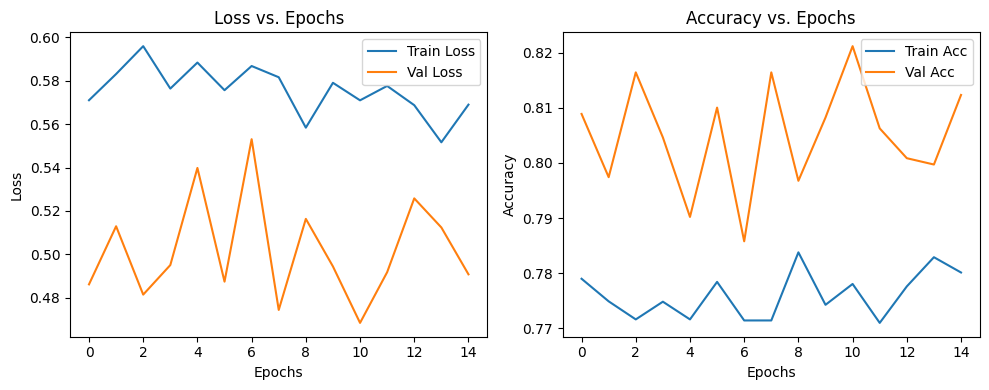

In [14]:

# --- 4. TRAINING AND VALIDATION ---

# Define the loss function and optimizer
# We only optimize the parameters of the new final layer we added
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=LEARNING_RATE)

# Training loop
best_val_acc = 0.0
start_time = time.time()

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(NUM_EPOCHS):
    print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc.item())
    val_accs.append(val_acc.item())

    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    train_loss = running_loss / total_samples
    train_acc = correct_predictions.double() / total_samples
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    val_loss = running_loss / total_samples
    val_acc = correct_predictions.double() / total_samples
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_weld_classifier.pth')
        print("Best model saved!")

end_time = time.time()
print(f"\n--- Training Finished in {(end_time - start_time)/60:.2f} minutes ---")
print(f"Best Validation Accuracy: {best_val_acc:.4f}\n")


# After training
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()



In [15]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc.item()


In [16]:
# --- 5. FINAL TESTING ---

print("--- Evaluating on Test Set ---")
# Load the best model weights that we saved during training
model.load_state_dict(torch.load('best_weld_classifier.pth'))

# Evaluate the model on the unseen test data
test_loss, test_acc = validate(model, test_loader, criterion, device) # Re-use the validate function
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


--- Evaluating on Test Set ---


Validating: 100%|██████████| 77/77 [00:06<00:00, 11.38it/s]

Final Test Loss: 0.4754
Final Test Accuracy: 0.8199


Testing: 100%|██████████| 77/77 [00:06<00:00, 11.71it/s]


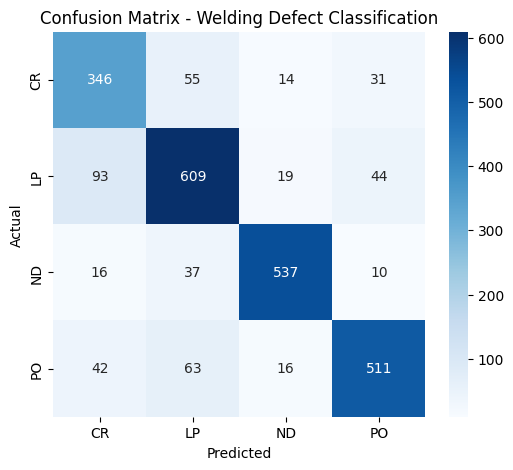


Classification Report:

              precision    recall  f1-score   support

          CR       0.70      0.78      0.73       446
          LP       0.80      0.80      0.80       765
          ND       0.92      0.90      0.91       600
          PO       0.86      0.81      0.83       632

    accuracy                           0.82      2443
   macro avg       0.82      0.82      0.82      2443
weighted avg       0.82      0.82      0.82      2443



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Predictions and True Labels ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
classes = train_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Welding Defect Classification")
plt.show()

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


In [19]:
import torch

# Save the entire model (architecture + weights)
torch.save(model, "weld_defect_resnet18_full.pth")

# OR (recommended) — save only the trained parameters
torch.save(model.state_dict(), "weld_defect_resnet18_weights.pth")

print("✅ Model saved successfully!")


✅ Model saved successfully!


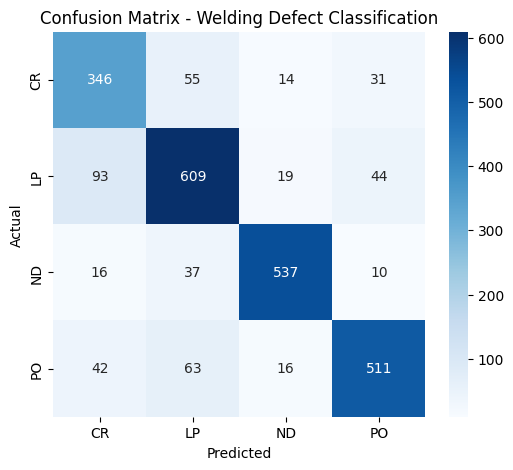

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Welding Defect Classification")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
